<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/ODE_Regression_with_Haiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Important links:
https://github.com/deepmind/dm-haiku/blob/main/examples/mnist.py
https://notebook.community/deepmind/dm-haiku/examples/haiku_lstms

In [1]:
!pip install git+https://github.com/deepmind/dm-haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-b8_sh0kb
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-b8_sh0kb
  Resolved https://github.com/deepmind/dm-haiku to commit f6439a1a234f1c46f0d515ade42de6f47553e7ef
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.10.dev0-py3-none-any.whl size=360287 sha256=9c6617bac9dc1cc97e1ed7ce3c9f785e4ea1d1d592574038bb0aa05f0f702832
  Stored in directory: /tmp/pip-ephem-wheel-cache-tikw470m/wheels/b1/df/f1/a357fa8f00c36052bdae1e1fd363650c0bd1e8c3959487b6fb
Successfully built dm-haiku


In [97]:
from typing import Iterator, NamedTuple

import haiku as hk
import jax
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import value_and_grad, jit, grad, random
from jax.numpy import pi, sin, cos
from jax.experimental.ode import odeint
from jax.config import config
import scipy as sci
import time
import numpy as np
import optax
from sklearn.model_selection import train_test_split

config.update("jax_enable_x64", True)

In [98]:
# Create our random keys, for data generation.
key, subkey = random.split(random.PRNGKey(int(time.time())))
gradient_updates = 15000
datapoints = 1024
batch_size = 16

# Make a function to create our datapoints.
def generate_data(t):
  return t + sin(t) + 0.3 * random.normal(subkey, shape=(datapoints,))

# Generate inputs and targets
x_truth = random.uniform(key, minval=0, maxval=10, shape=(datapoints,))
y_truth = generate_data(x_truth)

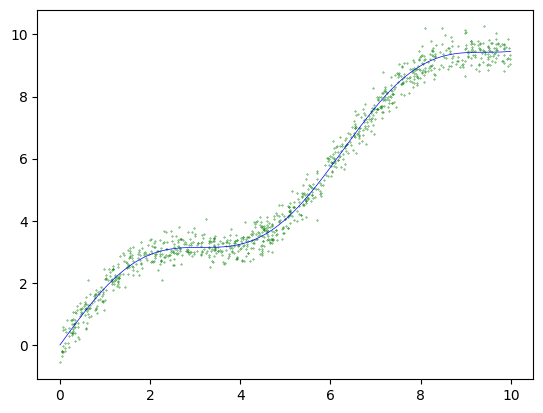

In [99]:
# Graph targets against actual curve.
plt.scatter(x_truth, y_truth, s=0.1, color='green')
fine_inputs = jnp.reshape(jnp.linspace(0, 10, 1000), (1000, 1))
plt.plot(fine_inputs, fine_inputs + sin(fine_inputs), lw=0.5, color='blue')

In [100]:
# Normalise our data between 0 and 1. We do this rather than (-1, -1) so that we can initialise from (0, 0).
x_truth = x_truth / jnp.max(x_truth)
y_truth = y_truth / jnp.max(y_truth)

# Split the data:
x_train, x_test, y_train, y_test = train_test_split(x_truth, y_truth, random_state=42)

# Data needs to be in this format to go into the model.
x_train = x_train.reshape(len(x_train),1)
x_test = x_test.reshape(len(x_test),1)

In [101]:
# Define our dataset class. This allows us to batch our data when training.
class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""
  # Initialise our dataset class. It needs the full x and y values and a batch size to be initialised.
  def __init__(self, x: jnp.array, y: jnp.array, batch_size: int):
    self._x = x
    self._y = y
    self._batch_size = batch_size
    self._length = self._x.shape[0]
    # The id stores where the next datapoint should be taken from, so when initialised it should be 0.
    self._idx = 0
    if self._length % batch_size != 0:
      msg = 'dataset size {} must be divisible by batch_size {}.'
      raise ValueError(msg.format(self._length, batch_size))

  # This is the function that gives us our next batch of data.
  def __next__(self):
    # Select the first and last datapoints in the batch. First will be the current value of the ID
    start = self._idx
    end = start + self._batch_size
    # Select our data.
    x, y = self._x[start:end], self._y[start:end]
    # This resets us back to 0 once we reach the end of our data.
    if end >= self._length:
      end = end % self._length
      # assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end
    return x, y

In [102]:
# Now that we have defined our dataset class, we can make our datasets:
train_dataset = Dataset(x_train, y_train, batch_size)
eval_dataset = Dataset(x_test, y_test, batch_size)

In [103]:
# Define a batch of data.
class Batch(NamedTuple):
  input: np.ndarray
  output: np.ndarray

# Define a training state, telling us what parameters we have and the state of the optimizer.
class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

In [104]:
# Define the neural network.
def FeedForward(x):
  mlp = hk.Sequential([
      hk.Linear(10), jax.nn.relu,
      hk.Linear(10), jax.nn.relu,
      hk.Linear(1),
  ])
  return mlp(x)

# Define our network and optimiser.
network = hk.without_apply_rng(hk.transform(FeedForward))
optimiser = optax.adam(1e-2)

In [105]:
# Define our mean squared error loss.
# The jits are hashed out because if it is jitted it does not print the actual data, it just prints the datatype, which does not help when debugging.
@jit
def dy_dx(y, x, weights):
  return network.apply(weights, jnp.array([x]))

@jit
def MeanSquaredErrorLoss(weights, batch):
  # Flatten our x inputs.
  xsteps = batch[0].flatten()
  # Order xsteps from smallest to largest, and reorder ybatch in the same order too.
  p = xsteps.argsort()
  xsteps = xsteps[p]
  ybatch = batch[1][p]

  # Insert the IC x value, 0, into the x labels.
  xsteps = jnp.insert(xsteps, 0, 0.)

  # Make our predictions.
  preds = odeint(dy_dx, 0., xsteps, weights)

  # This removes the fact that it is an array of arrays. Also, we do not need the initial value of 0.
  preds = preds.squeeze()[1:]

  return jnp.power(ybatch - preds, 2).mean()

In [106]:
@jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
  # This is how we define our stochastic gradient descent.

  # Find grads of loss w.r.t parameters, on this batch of the data
  grads = jax.grad(MeanSquaredErrorLoss)(state.params, batch)
  # Get the updates and the new optimser state from this.
  updates, opt_state = optimiser.update(grads, state.opt_state)
  # Apply the updates to the parameters.
  params = optax.apply_updates(state.params, updates)

  #return the training state with the new parameters and the optimiser.
  return TrainingState(params, opt_state)


In [107]:
#Initialising the parameters randomly.
rng = jax.random.PRNGKey(12)
initial_params = network.init(rng, x_train[:1])

# Initialise the optimiser and the define the state.
initial_opt_state = optimiser.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

# Print the structure of the network.
print("Weights Type : {}\n".format(type(initial_params)))

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape,initial_params[layer_name]["b"].shape))

Weights Type : <class 'dict'>

linear
Weights : (1, 10), Biases : (10,)

linear_1
Weights : (10, 10), Biases : (10,)

linear_2
Weights : (10, 1), Biases : (1,)



Step 0: train loss 0.4109198581114506, eval loss 0.31382289408366876
Step 1000: train loss 0.004228360727405791, eval loss 0.0031270138889618326
Step 2000: train loss 0.0036149830273997023, eval loss 0.0039306823823745275
Step 3000: train loss 0.0030232774268415512, eval loss 0.002061477130618884
Step 4000: train loss 0.006593371344774301, eval loss 0.004976837284655327
Step 5000: train loss 0.0026615877244287206, eval loss 0.0027488401196277424
Step 6000: train loss 0.001572636615098155, eval loss 0.0009535355912391858
Step 7000: train loss 0.0015906682946817796, eval loss 0.0012973619686064385
Step 8000: train loss 0.001041006871074938, eval loss 0.0018156014619761498
Step 9000: train loss 0.0004354438161707567, eval loss 0.0006903122391249824
Step 10000: train loss 0.0009886468660531638, eval loss 0.0010635400377984666
Step 11000: train loss 0.0013208136924119163, eval loss 0.0014609564580362216
Step 12000: train loss 0.0006509765107079973, eval loss 0.0008925625954190365
Step 13000

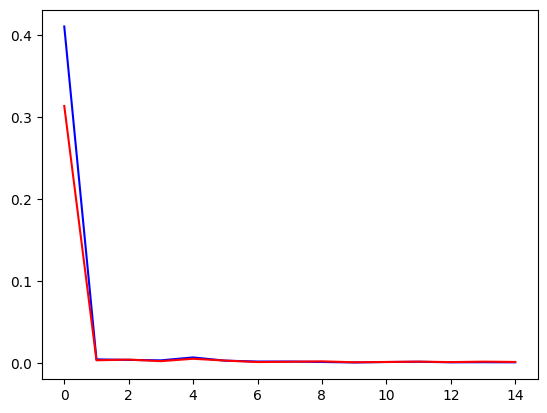

In [108]:
# Training & evaluation loop.
train_loss_list = []
val_loss_list = []
for step in range(gradient_updates):
  # Do stochastic gradient descent on a batch of training examples.
  state = update(state, next(train_dataset))

  # Print the training and evaluation loss every 1000 time steps.
  if step % 1000 == 0:
    train_loss_list.append(MeanSquaredErrorLoss(state.params, next(train_dataset)))
    val_loss_list.append(MeanSquaredErrorLoss(state.params, next(eval_dataset)))
    print("Step {}: train loss {}, eval loss {}".format(step, train_loss_list[-1], val_loss_list[-1]))

plt.plot(train_loss_list, color="b")
plt.plot(val_loss_list, color="red")

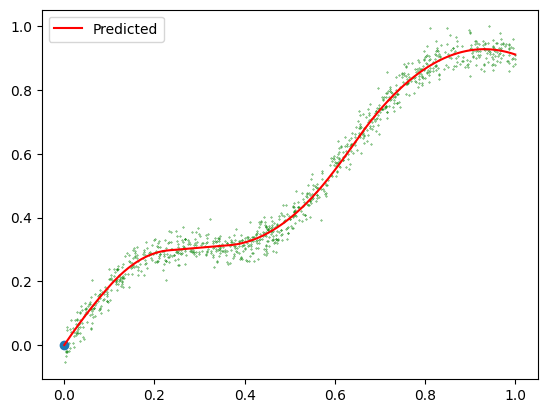

In [110]:
 # Graph our prediction against the actual curve and the testing data

plt.scatter(x_truth, y_truth, s=0.1, color='green')
fine_inputs = jnp.reshape(jnp.linspace(0, 1, 1000), (1000, 1))

preds = odeint(dy_dx, 0., fine_inputs.flatten(), state.params)
plt.plot(0., 0., "o")
plt.plot(fine_inputs, preds, color='red', label="Predicted")
plt.legend()